# Document Clustering and Topic Modeling 

## Contents

* [Part 1: Data Preview](#Part-1:-Data-Preview)
* [Part 2: Text Preprocessing ](#Part-2:-Text-Preprocessing)
* [Part 3: Topic Modeling with K-Means and LDA ](#Part-3:-Topic-Modeling)

__*Dataset:*__<br> [E-Commerce Review Data](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)


# Part 1: Data Preview 

In [1]:
# for data exploration
import pandas as pd
import numpy as np
import datetime as dt 

# remove warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# for text processing 
import re
import nltk 

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string 
string.punctuation

from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator

# gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
from plotly.subplots import make_subplots
import pyLDAvis
# import pyLDAvis.gensim #dont skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

print('✔️ Libraries Imported!')

✔️ Libraries Imported!


### 1.1 Understand the Raw Dataset and Data Selection

In [2]:
# Load data into dataframe, skip the error lines
df = pd.read_csv('watch_reviews.tsv', sep='\t', error_bad_lines=False)
df.head(3)

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fie

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31


In [3]:
# check for the time range of the dataset
time_range=pd.Series(pd.to_datetime((df.review_date.sort_values(ascending=False)))).dropna()
time_diff=(time_range.iloc[0]-time_range.iloc[-1])

print(f'The dataset has a time period from {time_range.iloc[-1].year} to {time_range.iloc[0].year}, in total of {time_diff}.')


c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The dataset has a time period from 2001 to 2015, in total of 5261 days 00:00:00.


In [4]:
# check the dataset size and number of features 
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

Dataset contains 960204 rows and 15 columns.


c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# convert the data type
df['review_body'] = df['review_body'].astype('string')

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2 Building Up Text Corpus

Due to the CPU limit, here we define the product that have over 300 reveiews as `popular products`, and we would only continue the data cleaning and processing on these set of data due to the limitation of memory and computation power. <br><br>
And since there's only 16 missing reviews out of the whole 13.24k datapoints, here we directly drop the missing values.

In [6]:
# groupby's filter is the equivalent of SQL's GroupBy-Having
popular_products = df.groupby(df['product_id']).filter(lambda x: x['review_id'].count() >= 300)

print(f'Number of datapoints matching the criteria is: {len(popular_products)}')

# check for the null values for the new dataset 
popular_products.isnull().sum()

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of datapoints matching the criteria is: 132407


marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline       0
review_body          16
review_date           0
dtype: int64

In [7]:
# seperate the `review body` out and transform to list for nlp processing
popular_products = popular_products.dropna(subset=['review_body'])['review_body']

# a snippet of text 
data = pd.DataFrame(popular_products)
data[5:10]

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review_body
38,This is now my everyday watch. Easy to read w...
44,"Have worn it constantly, love the light at night"
46,Great product . Love the continous innovation ...
57,"Alrighty, after seeking out the ultimate low-p..."
65,"Man watch for woman, just a right size and des..."


# Part 2: Text Preprocessing

## Text preprocessing/cleaning steps:

1. *Lower Casing*
    - The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.
    - Pros: More helpful for text featurization like frequency, TF-IDF as it reducing the duplicates. 
    - Cons: May not be helpful in __*sentiment analysis*__ when upper cases often refers to anger.
    <br><br>
2. [Removal of Punctuation](https://datagy.io/python-remove-punctuation-from-string/)
    - The `string.punctuation` in Python contains the following punctuations: <br>
        - !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
    <br><br>
3. *Removal of Stopwords*
    - The commonly occuring words in a language that doesn't provides valuable information.
    <br><br>
4. *Stemming* 
    - Convert words to it's word stem, base or root. Porter Stemmer is for English language. If we are working with other languages, we can use `snowball stemmer`. 
    <br><br>
5. *Lemmatization* 
    - Convert the word to it's original form based on its context, slower but more linguistic revalent.
    - _NLTK_, _Stanford_, _Bitext_ Lemmatizer available.
    <br><br> 
6. *Removal of emojis*
    - For social media text corpuses, an explosion usage of emoji should also be taken care of. Functions credit to [this repo](https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b).
    - For sentiment analysis or similar purposes, the emotion delivered from emojis are unnegligible, and thanks to [this repo](https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py), we can make use this dictionary to conver the emojis to corresponding words.    
    - For this project's purposes, since the data ends in 2015 and not as abundant emojis are available by then, we can skip this part of preprocessing. 
    <br><br>
7. *Removal of URLs* 
    - When doing Twitter/Reddit analysis, there's good chance of having URLs present in data, we might need to remove it for analysis.
    <br><br> 
8. *Removal of HTML tags*
    - When data is scrapped from websites, we might end up having html strings as part of the text. Can remove it by using Regex or a more elegant way of using BeautifulSoup.

## 2.1 Stemming 

In [8]:
def clean_text_stemming(var):
    """
    Function for text preprocessing with Poter Stemming.
    """
    sw = set(stopwords.words('english'))
    ps = PorterStemmer() 

    # tokenize the word using nltk  
    my_text = nltk.word_tokenize(var)
    
    # remove not english characters, lower case and remove the white apace at end 
    my_text = re.sub('[^A-Za-z0-9]+', " ", var).lower().strip()

    # remove the stop words 
    my_text = [word for word in my_text.split() if word not in sw]

    # stemming
    my_text = [ps.stem(word) for word in my_text]

    # removal of URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    my_text = url_pattern.sub(r'', ' '.join(my_text))

    # removal of HTML Tags
    my_text = BeautifulSoup(my_text, "lxml").text

    # convert the text to list as the vectorized words  
    my_text = my_text.split(" ")
    
    return my_text

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
a = data['review_body'][50:60]
a.apply(lambda x: clean_text_stemming(x))

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


375                [love, comfort, feel, weak, bracelet]
377                                       [excel, watch]
382          [exactli, need, want, awesom, great, price]
398    [seem, cheap, watch, accur, time, keep, possib...
400    [ok, watch, day, easili, say, best, cheapli, p...
409      [excel, son, love, want, swim, yet, pass, test]
450                                       [pretti, good]
453    [great, watch, great, water, resist, substanti...
497                                         [niec, love]
513    [recommend, watch, high, qualiti, perform, adv...
Name: review_body, dtype: object

We can see that words like _someone_ and _compare_ have their _e_ at the end chopped off due to stemming. This is not intented, and we can use Lemmatization in such cases.

## 2.2 Lemmatization 

In [10]:
def clean_text_lemma(var):
    """
    Function for text preprocessing with Lemmatizing with POS tag.
    """
    sw = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N": wordnet.NOUN,"V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    
    # tokenize the word using nltk  
    my_text = nltk.word_tokenize(var)
    
    # remove not english characters, lower case and split the text 
    my_text = re.sub('[^A-Za-z0-9]+', " ", var).lower().strip() 

    # remove the stop words 
    my_text = [word for word in my_text.split() if word not in sw]

    # lemmatizing 
    pos_tagged_text = nltk.pos_tag(my_text) 
    my_text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

    # removal of URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    my_text = url_pattern.sub(r'', my_text)

    # removal of HTML Tags
    my_text = BeautifulSoup(my_text, "lxml").text

    # convert the text to list as the vectorized words  
    my_text = my_text.split(" ")

    return my_text

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
b = data['review_body'][50:60]
b.apply(lambda var: clean_text_lemma(var))


c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


375            [love, comfortable, feel, weak, bracelet]
377                                   [excellent, watch]
382         [exactly, need, want, awesome, great, price]
398    [seem, cheap, watch, accurate, time, keep, pos...
400    [ok, watch, day, easily, say, best, cheaply, p...
409    [excellent, son, love, want, swim, yet, pass, ...
450                                       [pretty, good]
453    [great, watch, great, water, resistance, subst...
497                                        [niece, love]
513    [recommend, watch, high, quality, perform, adv...
Name: review_body, dtype: object

The experiment above shows that words are more revelant to their original meaning when lemmatizing is applied. Therefoer we would use the `clean_text_lemma` function for the whole text transformation. 

## 2.3 TF-IDF Tokenization

In [12]:
tfidf_model = TfidfVectorizer(max_df=0.99,
                              max_features=1000, # normally wouldn't exited this range
                              min_df=0.01, 
                              stop_words='english',
                              use_idf=True,
                              tokenizer=clean_text_lemma,
                              ngram_range=(1,3)) # 1-gram, 2-gram, 3-gram included 

tfidf_matrix = tfidf_model.fit_transform(data['review_body']) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In total, there are 132391 reviews and 387 terms.


In [13]:
# save the terms identified by TF-IDF and have a look 
tf_selected_words = tfidf_model.get_feature_names()

# print out word snippet 
tf_selected_words[380:]

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['worth', 'wrist', 'wrong', 'year', 'year ago', 'year old', 'zone']

In [14]:
tfidf_matrix.todense()

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


matrix([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.2626663,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]])

Now as the text has been transformed into numbers in a way that machine learning algorithm can understand, which is the process as _**text vectorization**_, we can feed the TF-IDF score to algorithms for more interesting exploration. 

# Part 3: Topic Modeling

Both K-means and Latent Dirichlet Allocation (LDA) are **unsupervised** **learning** algorithms, where the user needs to decide a priori the parameter *K*, respectively the number of clusters and the number of topics.

If both are applied to assign *K* topics to a set of *N* documents, the most evident difference is that K-means is going to **partition** the *N* documents in *K* **disjoint** clusters (*i.e.* topics in this case). 

On the other hand, LDA assigns a document to a **mixture** of topics. Therefore each document is characterized by **one or more** topics (e.g. *Document D belongs for 60% to Topic A, 30% to topic B and 10% to topic E)*. Hence, LDA can give *more realistic results* than k-means for topic assignment.

## 3.1 K-Means Clustering

### 3.1.1 Implementation

In [15]:
# k-means clustering
from sklearn.cluster import KMeans

# initialize with 5 clusters
num_clusters = 5
km = KMeans(n_clusters=num_clusters).fit(tfidf_matrix)

clusters = km.labels_.tolist()

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.1.2 Analyze K-means Result

In [16]:
# create DataFrame films from all of the input files.
product = { 'review': data['review_body'], 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
frame.head(10)

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review,cluster
2,Scratches,3
3,"It works well on me. However, I found cheaper ...",3
26,It works well with nice simple look.,3
29,This watch is a very beautiful time piece. Thi...,1
34,Awesome watch for the price,3
38,This is now my everyday watch. Easy to read w...,0
44,"Have worn it constantly, love the light at night",0
46,Great product . Love the continous innovation ...,3
57,"Alrighty, after seeking out the ultimate low-p...",1
65,"Man watch for woman, just a right size and des...",3


In [18]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cluster
3,87700
2,15589
0,12126
1,11743
4,5233


In [19]:
km.cluster_centers_.shape

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5, 387)

The assumption underpins is that using the `cluster_center_` to represent the whole cluster, and the higher the TF-IDF value is, the higher representation power of this word is. Therefore, I choose the top _**6**_ words according to their TF-IDF score to represent it's cluster. And see if there's some pattern that we can find from it's clustering result. 

In [20]:
# sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for j in order_centroids[i, :6]: # replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[j])
        print (tf_selected_words[j] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews)")
    print ()

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster 0 words:love,love watch,watch,gift,buy,husband,
Cluster 0 reviews (12126 reviews)

Cluster 1 words:br,br br,watch,time,look,band,
Cluster 1 reviews (11743 reviews)

Cluster 2 words:great,watch,great watch,price,look,work,
Cluster 2 reviews (15589 reviews)

Cluster 3 words:watch,time,like,nice,look,work,
Cluster 3 reviews (87700 reviews)

Cluster 4 words:good,product,good watch,watch,price,good price,
Cluster 4 reviews (5233 reviews)



__*Analysis for the K-means clustering results:*__ <br>

From the above clustering results, we can see that the word `watch` is showing up in each ranking, which is not surprising but redundant this case, for the model imporvement, we could add this domain related word into the stopwords. <br><br>
Most reviews fell into the _cluster 5_ with a ratio of 66.24%, yet the tokenized word from it is not so informative, as it just praising the punctuality of the watch. <br><br>

_**Business Insight**_

Cluster 0 though, with the words like `love`, `gift`, `husband` gathering, we can infer that this watch have being giving out as present to the customer's spouse and as a way of showing their affection. 
I would suggest the brand to have some promotion activities when it comes to Vlentine's Day, and can run an A/B test on whether the promotion would help increase the sales. 

## 3.2 Latent Dirichlet Allocation(LDA)

Gensim's LDA requires the data in a certain format. Firstly, it needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.

### 3.2.1 Create the dictionary and corpus needed for Topic Modeling

In [21]:
# process all the data using lemmatization
data_lemmatized = data['review_body'].apply(lambda x: clean_text_lemma(x))

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# create dictionary
id2word=corpora.Dictionary(data_lemmatized)

#create corpus with Term Document Frequency
corpus=[id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


Gensim creates a unique id for each word in the document, the produced corpus shown above is a mapping of (word_id, word_frequency). <br>
For instance, (8,1) above implies, word id 8 occurs once in the first document. And this will be used as the input by the LDA model of Gensim. 

In [23]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('scratch', 1)]]

Let's now build the topic model with LDA. We'll define 5 topics to start with. The hyperparameter `alpha` affects sparsity of the document-topic (theta) distributions, whose default value is 1. Similarly, the hyperparameter `eta` can also be specified, which affects the topic-word distribution's sparsity.<br>
`chunksize` is the number of documents to be used in each training chunk. `update_every` determines how often the model parameters should be updated and passes is the total number of training passes.

### 3.2.2 Build the model and view the topics

In [24]:
# Build LDA model
lda_model= gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The above LDA model is built with 5 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. We can see the keywords for each topic and the importance(weight) of each keyword using `lda_model.print_topics()` as shown next. 

In [25]:
# print the 5 topics
lda_model.print_topics()

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.102*"great" + 0.090*"good" + 0.076*"work" + 0.068*"price" + 0.051*"love" + 0.026*"quality" + 0.025*"recommend" + 0.024*"product" + 0.022*"perfect" + 0.019*"night"'),
 (1,
  '0.051*"light" + 0.043*"feature" + 0.042*"read" + 0.038*"casio" + 0.033*"alarm" + 0.031*"see" + 0.026*"button" + 0.022*"digital" + 0.020*"hand" + 0.019*"g"'),
 (2,
  '0.152*"time" + 0.045*"set" + 0.039*"keep" + 0.028*"date" + 0.023*"3" + 0.022*"change" + 0.021*"clock" + 0.016*"accurate" + 0.016*"black" + 0.015*"receive"'),
 (3,
  '0.056*"br" + 0.017*"day" + 0.012*"second" + 0.011*"take" + 0.011*"first" + 0.011*"back" + 0.011*"pin" + 0.010*"amazon" + 0.010*"month" + 0.009*"5"'),
 (4,
  '0.125*"watch" + 0.025*"look" + 0.023*"band" + 0.023*"one" + 0.019*"like" + 0.018*"get" + 0.016*"buy" + 0.015*"use" + 0.013*"year" + 0.013*"would"')]

### 3.2.3 Model evaluation and visualization


Finally we'd like to evalue how good a given model is, and normally we'd reference to coherence score. 

In [27]:
# compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# compute coherence score
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.966787747024273

Coherence Score: 0.4633478978096902


In [55]:
# visulaise the topics
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.302494  0.012015       1        1  46.507909
3     -0.245507  0.018295       2        1  26.146674
2      0.184462 -0.214125       3        1   9.301268
0      0.206592  0.378176       4        1   9.268859
1      0.156947 -0.194360       5        1   8.775290, topic_info=           Term           Freq          Total Category  logprob  loglift
68        watch  193792.000000  193792.000000  Default  30.0000  30.0000
65         time   47154.000000   47154.000000  Default  29.0000  29.0000
103       great   31706.000000   31706.000000  Default  28.0000  28.0000
36         good   27966.000000   27966.000000  Default  27.0000  27.0000
21           br   48878.000000   48878.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
597        real    1907.753733    1908.211075   Topic5  -5.0349   2.4330
2977  countdown    1812.808989    1813.262145   Topic5  -5.0859   2.4330
684         see    9096.808424    9196.886644   Topic5  -3.4729   2.4223
498        hand    5824.856227   10488.098053   Topic5  -3.9187   1.8451
317         old    2597.984958    5481.944456   Topic5  -4.7261   1.6865

[196 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
86        2  0.999917      1
228       2  0.999910      2
385       3  0.999961      3
469       2  1.000003      4
409       2  0.999971      5
...     ...       ...    ...
9         4  0.941488   work
187       1  0.999993  would
71        1  0.999996  wrist
151       1  0.999988   year
1625      3  0.999895   zone

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

From the pyLDAvis's output, we can see that each bubble on the left hand side represents a topic, and the larger the bubble, the more prevalent is that topic. Normally, a good topic model will have _fairly big, non-overlapping bubbles scattered throughout the chart_ instead of being clustered in one quadrant.<br><br>
A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart. Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward, as now it seems that two bubbles on the left are largely overlapped. 

### 3.2.4 Hyperparameter Tuning: Number of Topics and Alpha

The below `compute_coherence_values()` trains multiple LDA models and provides the models and their corresponding coherence scores. <br><br>

`alpha` is a parameter that controls the _prior distribution over topic weights_ in each document, while `eta` is a parameter for the prior distribution over word weights in each topic. In gensim, both default to a symmetric, _1 / num_topics prior_.<br><br>

These two parameters can be thought of as __*smoothing parameters*__ when we compute how much each document _"likes" a topic_ (in the case of alpha) or how much each topic _"likes" a word_ (in the case of eta). A higher alpha makes the document preferences "smoother" over topics, and a higher eta makes the topic preferences "smoother" over words.<br><br>

Since we only have one document for this assignment, we'll focus on `alpha` for hyperparameter tuning.


In [41]:
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    num_topics_range: A list of topics range 
    alpha_range: A list of alpha range

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))

    return model_list, coherence_values

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# build models accross a range of num_topics and alpha(this takes a long time)
num_topics_range= [2,3,5,10]

# 1 --> high, 0.1 --> original, 0.01 --> low 
alpha_range=[0.01,0.1,1]
model_list, coherence_values= compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,\
                                                       num_topics_range=num_topics_range,alpha_range=alpha_range)

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# change the presentation into dataframe format 
coherence_df = pd.DataFrame(coherence_values, columns=['alpha','num_topics','coherence_value'])
coherence_df

c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,alpha,num_topics,coherence_value
0,0.01,2,0.431145
1,0.01,3,0.448082
2,0.01,5,0.477359
3,0.01,10,0.479134
4,0.10,2,0.430488
5,0.10,3,0.473921
6,0.10,5,0.459109
7,0.10,10,0.470194
8,1.00,2,0.448637
9,1.00,3,0.445851


c:\Users\hs324\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


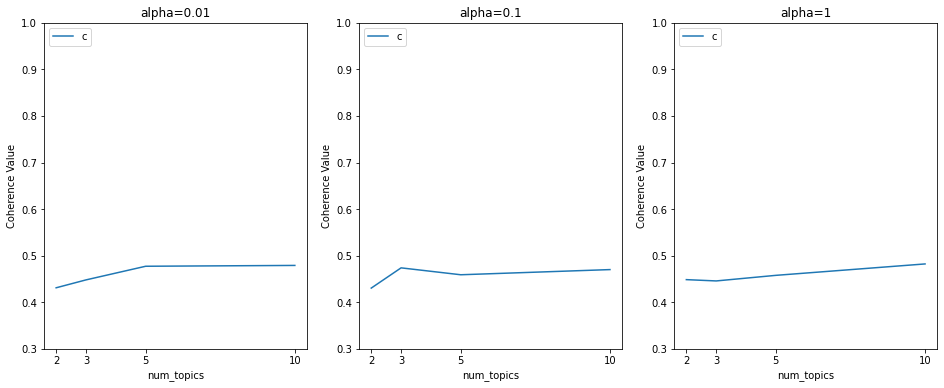

In [48]:
def plot_coherence(coherence_df,alpha_range,num_topics_range):
    """
    Came up with the plots that shows the change of coherence score given different combination of alpha and number of topics. 
    """
    plt.figure(figsize=(16,6))
    for i,val in enumerate(alpha_range):
        # index is the index of alpha 
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0.30,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df,alpha_range,num_topics_range)

__*Analysis for the Optimal Number of Topics*__<br><br>
From the above subplots, we can see that when setting alpha as 0.01, we reaches the highest coherence value at the number of topic being 5, when alpha being set as 0.1, the optimal number of topics is 3, while when alpha being 1, the coherence value is showing a slightly upwards patteren without a turning point. This is likely because when the alpha is going higher, the weight is much more evenly distributed across the topics.<br>

In combination with the previous viz of LDA result, we would go with the defalut alpha(0.1) and choose 3 as number of topic. 